### Kernel PCA and Clustering

The purpose of this notebook is to check if the data is nonlinerarly separable. Initial clustering suggests poor fit using classical PCA.

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import KernelPCA
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

Unfortunately, a full KernelPCA requires 428 GB of memory. We take a random $\frac{1}{12}$ of our data with a set seed and write the data to a file in order to speed up potential future runs.

In [2]:
# # Reading data

# flattened_data = pd.read_csv("processed_galaxy_data/flattened_normalized_images.csv", header = None)
# labels = pd.read_csv("processed_galaxy_data/labels_mappings_filtered.csv")

# # Subsetting data

# subset_data = flattened_data.sample(frac = 0.08, random_state = 42)
# subset_labels = pd.DataFrame(np.array(labels["shape_label"])[np.array(subset_data.index)])

# # Writing data to files.

# np.savetxt('processed_galaxy_data/kpca_subset.csv', subset_data, delimiter=',')
# subset_labels.to_csv("processed_galaxy_data/kpca_labels.csv", index = False)

In [5]:
#fitted_kernel_pca = KernelPCA(kernel = "rbf")
#fitted_kernel_pca.fit_transform(subset_data)

Next, we need to see how many PCs of the kernel transform we need. Similar to PCA, we pick a value that is above 90%.

(array([   66,    67,    68, ..., 19162, 19163, 19164], dtype=int64),)

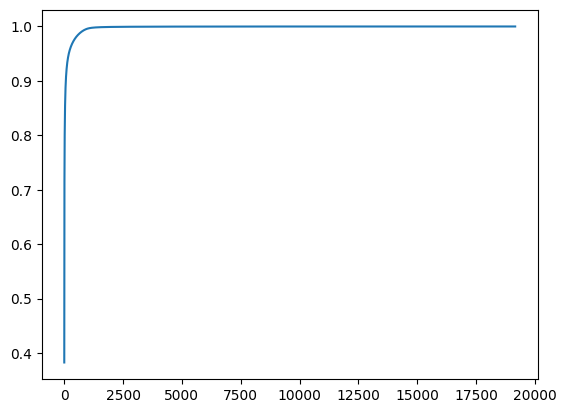

In [17]:
variance_array = np.cumsum(fitted_kernel_pca.eigenvalues_) / np.sum(fitted_kernel_pca.eigenvalues_)
plt.plot(variance_array)
np.where(variance_array > 0.9)

We set `n_components = 66` and comment out the full KernelPCA code. We can then rerun the algorithm using this new parameter to fit our data. Similarly, we write the data to a file.

In [9]:
# # Rerunning kPCA, fitting our data, and writing to file.

# fitted_kernel_pca = KernelPCA(kernel = "rbf", n_components = 66)
# kpca_data = fitted_kernel_pca.fit_transform(subset_data)
# np.savetxt('processed_galaxy_data/kernel_pca_normalized.csv', kpca_data, delimiter=',')

Now that we have our data represented in a new vector space, let's see if clustering can produce some stronger results. Let's try a GridSearch for DBSCAN to see if any set of hyperparameters create a suitable model.

In [4]:
kpca_data = pd.read_csv("processed_galaxy_data/kernel_pca_normalized.csv", header = None)
subset_labels = pd.read_csv("processed_galaxy_data/kpca_labels.csv")

In [56]:
samples = [5, 10]
epsilon = np.arange(0.001, 0.15, 0.005)
dbs_ari = pd.DataFrame(index = samples, columns = epsilon)
for sample in samples:
    for epsi in epsilon:
        dbs = DBSCAN(min_samples = sample, eps = epsi)
        y_labels = dbs.fit(kpca_data).labels_
        dbs_ari.loc[sample, epsi] = metrics.adjusted_rand_score(subset_labels["0"], y_labels)

In [57]:
dbs_ari

,0.001,0.006,0.011,0.016,0.021,0.026,0.031,0.036,0.041,0.046,...,0.101,0.106,0.111,0.116,0.121,0.126,0.131,0.136,0.141,0.146
5,0.0,0.0,0.0,0.000345,0.001033,0.000552,-0.000253,-0.00128,-0.002146,-0.001058,...,-0.000913,-0.000962,-0.000862,-0.000631,-0.000511,-0.000326,-0.000299,-0.000187,-0.000187,-0.000085
10,0.0,0.0,0.0,0.000235,0.001507,0.000754,-0.000258,-0.001317,-0.001714,-0.000959,...,-0.000666,-0.000947,-0.000901,-0.000762,-0.000552,-0.000349,-0.000329,-0.000244,-0.000208,-0.000133


In [58]:
dbs_ari.max()

0.001         0.0
0.006         0.0
0.011         0.0
0.016    0.000345
0.021    0.001507
0.026    0.000754
0.031   -0.000253
0.036    -0.00128
0.041   -0.001714
0.046   -0.000959
0.051    -0.00099
0.056   -0.001314
0.061   -0.001138
0.066   -0.001495
0.071   -0.001892
0.076   -0.001636
0.081   -0.000838
0.086   -0.000561
0.091   -0.000895
0.096   -0.000879
0.101   -0.000666
0.106   -0.000947
0.111   -0.000862
0.116   -0.000631
0.121   -0.000511
0.126   -0.000326
0.131   -0.000299
0.136   -0.000187
0.141   -0.000187
0.146   -0.000085
dtype: object

DBSCAN, even after KernelPCA, is not performing well. What about Gaussian Mixture Models?

In [60]:
gmm = GaussianMixture(n_components = 4)
pipe_gmm = Pipeline([
    ("gmm", gmm)
])
param_grid_gmm = {
    "gmm__covariance_type": ["full", "tied", "spherical", "diag"]
}
grid_gmm = GridSearchCV(pipe_gmm, param_grid_gmm, scoring = "adjusted_rand_score")

In [62]:
fitted_gmm = grid_gmm.fit(kpca_data, subset_labels["0"])

C:\Users\jalen\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


In [63]:
results_gmm = pd.DataFrame(grid_gmm.cv_results_['params'] )
results_gmm['Mean Adjusted Rand Index'] = grid_gmm.cv_results_['mean_test_score']
results_gmm.head()

,gmm__covariance_type,Mean Adjusted Rand Index
0,full,-0.000728
1,tied,-0.000651
2,spherical,-0.000275
3,diag,-0.001325


GMMs do not perform well on kerneled data, either. Our procedures would seem to suggest that the data structure is too noisy, dense, or overlapping, even after projecting to higher dimensions.